### Leitura das métricas logadas

In [1]:
from pathlib import Path
import os
from pprint import pprint

RESULTS_DIR = Path.cwd().parent / 'results'

#### Fase 1

In [2]:
import polars as pl
from tensorboard.backend.event_processing import event_accumulator

In [3]:
# Carregar os dados dos logs do TensorBoard
def load_events_data(log_dir: str):
    ea = event_accumulator.EventAccumulator(log_dir)
    ea.Reload()

    # Acessar os dados de scalars (loss, accuracy, etc.)
    tags = ea.Tags()['scalars']

    # Criar um dataframe vazio para armazenar os dados
    data_train = {}
    data_test = {}

    # Iterar sobre as tags e extrair os valores
    for tag in tags:
        if 'step' not in tag and tag != 'epoch' and 'time' not in tag:
            # Como estou desconsiderando o métricas a nível de step, 
            # os resultados não precisam de ordenamento ao longo do tempo        
            events = ea.Scalars(tag)
            for event in events:
                step = event.step  # ignorado, a nível de época
                value = event.value
                if 'train' in tag:
                    if not data_train.get(tag):
                        data_train[tag] = []
                    data_train[tag].append(value)
                elif 'test' in tag:
                    if not data_test.get(tag):
                        data_test[tag] = []
                    data_test[tag].append(value)



    # Mostrar o DataFrame's
    df_train = pl.DataFrame(data_train)
    df_test = pl.DataFrame(data_test)
    
    return df_train, df_test

    # # Salvar o DataFrame como CSV (se necessário)
    # df.write_csv(RESULTS_DIR/f"phase_1/csvs/tensorboard_data_polars_{'_'.join(log_dir.split(os.path.sep)[-3:])}.csv")
    # print(df)

In [52]:
#          model | repet | kfolditer | metric x | metric y | ...
#                                       value1  |  value1  | ...
#                                       value2  |  value2  | ...
#                                       value3  |  value3  | ...
#                                       value4  |  value4  | ...
#                                       value5  |  value5  | ...
df_list_train = []
df_list_test = []


for events_dir in RESULTS_DIR.glob('phase_1/tb_logs/*/repet*/kfolditer*'):
    repet = int(events_dir.parents[0].name[-1])
    model = events_dir.parents[1].name
    kfolditer = int(events_dir.name[-1])

    # carrega os datos de uma iteração do kfold
    df_train, df_test = load_events_data(str(events_dir))

    # Organização dos dados 
    df_train = df_train.with_columns([
        pl.lit(model).alias('model'),
        pl.lit(repet).alias('repet'),
        pl.lit(kfolditer).alias('kfolditer'),
    ])
    df_test = df_test.with_columns([
        pl.lit(model).alias('model'),
        pl.lit(repet).alias('repet'),
        pl.lit(kfolditer).alias('kfolditer'),
    ])

    df_list_train.append(df_train)
    df_list_test.append(df_test)


df_train = pl.concat(df_list_train)
df_test = pl.concat(df_list_test)

In [44]:
df_train.write_csv(RESULTS_DIR / 'phase_1/csvs/train_epoch_results.csv')
df_test.write_csv(RESULTS_DIR / 'phase_1/csvs/test_epoch_results.csv')

### Média Geral


In [53]:
df_train

epoch_train_per_image_iou,epoch_train_dataset_iou,epoch_train_per_image_sensitivity,epoch_train_dataset_sensitivity,epoch_train_per_image_specificity,epoch_train_dataset_specificity,epoch_train_per_image_f1,epoch_train_dataset_f1,epoch_avg_loss_train,model,repet,kfolditer
f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i32,i32
0.268383,0.789286,0.294094,0.907532,0.32503,0.98372,0.279405,0.877813,0.087774,"""dpt_256x256_pngs_preproc""",3,4
0.298027,0.93804,0.311366,0.963725,0.328404,0.992201,0.305371,0.967811,0.030927,"""dpt_256x256_pngs_preproc""",3,4
0.301673,0.944391,0.31354,0.967732,0.328903,0.993162,0.308485,0.971225,0.026974,"""dpt_256x256_pngs_preproc""",3,4
0.306531,0.954946,0.316468,0.974447,0.329483,0.994323,0.312612,0.976842,0.021845,"""dpt_256x256_pngs_preproc""",3,4
0.30791,0.957948,0.317498,0.976342,0.329661,0.994715,0.313698,0.978425,0.019897,"""dpt_256x256_pngs_preproc""",3,4
…,…,…,…,…,…,…,…,…,…,…,…
0.274329,0.808735,0.294024,0.913341,0.324892,0.98491,0.284288,0.891574,0.08618,"""segformer_256x256_pngs_preproc""",2,3
0.299105,0.937735,0.3108,0.964447,0.328363,0.992984,0.306254,0.967642,0.031121,"""segformer_256x256_pngs_preproc""",2,3
0.302343,0.945823,0.313168,0.969578,0.328876,0.994013,0.30883,0.971989,0.026754,"""segformer_256x256_pngs_preproc""",2,3


In [54]:
# treino
geral_mean_df = (
    df_train.group_by('model')
    .agg([pl.col(c).mean() for c in df_train.columns if 'epoch' in c])
)


In [55]:
geral_mean_df

model,epoch_train_per_image_iou,epoch_train_dataset_iou,epoch_train_per_image_sensitivity,epoch_train_dataset_sensitivity,epoch_train_per_image_specificity,epoch_train_dataset_specificity,epoch_train_per_image_f1,epoch_train_dataset_f1,epoch_avg_loss_train
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""dpt_256x256_pngs_preproc""",0.296258,0.918791,0.310182,0.957865,0.328202,0.991704,0.303713,0.955634,0.037858
"""segformer_256x256_pngs_preproc""",0.296816,0.921404,0.309446,0.958948,0.32807,0.992258,0.30401,0.957643,0.037801
"""unet++_256x256_pngs_preproc""",0.294939,0.912131,0.31014,0.955069,0.32913,0.992972,0.301348,0.951841,0.04191
"""deeplabv3+_256x256_pngs_prepro…",0.297074,0.921691,0.308853,0.958299,0.327444,0.99106,0.304535,0.957782,0.038187


/tmp/ipykernel_29524/394043839.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(geral_mean_df["model"], rotation=45, ha="right")
/tmp/ipykernel_29524/394043839.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(geral_mean_df["model"], rotation=45, ha="right")
/tmp/ipykernel_29524/394043839.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(geral_mean_df["model"], rotation=45, ha="right")


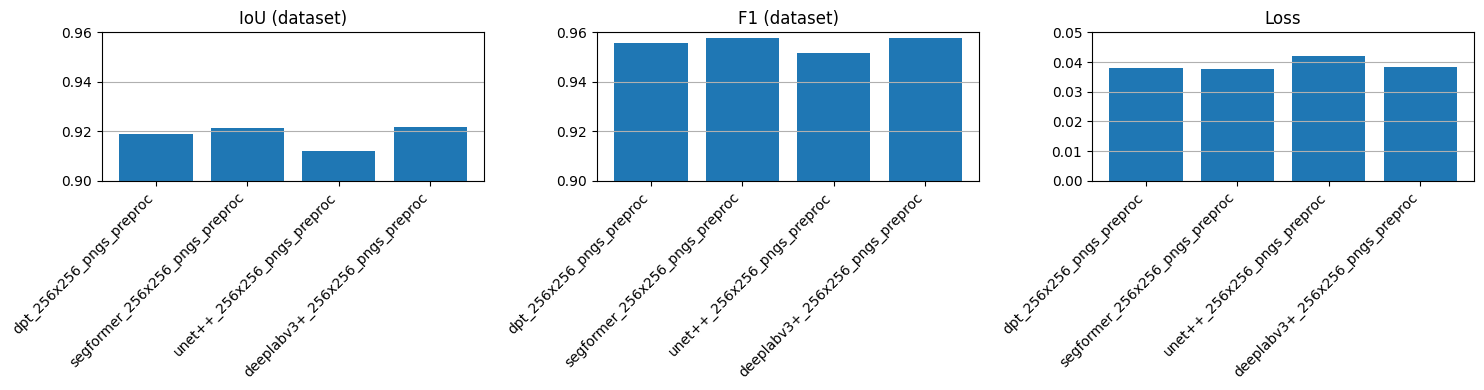

In [56]:
import matplotlib.pyplot as plt
import polars as pl

metrics = {
    "IoU (dataset)": "epoch_train_dataset_iou",
    "F1 (dataset)": "epoch_train_dataset_f1",
    "Loss": "epoch_avg_loss_train",
}

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for ax, (title, col) in zip(axs, metrics.items()):
    ax.set_ylim(0.90, 0.96)
    if title=='Loss':
        ax.set_ylim(0, 0.05)

    ax.bar(geral_mean_df["model"], geral_mean_df[col])
    ax.set_title(title)
    ax.set_xticklabels(geral_mean_df["model"], rotation=45, ha="right")
    ax.grid(True, axis="y")

plt.tight_layout()
plt.show()

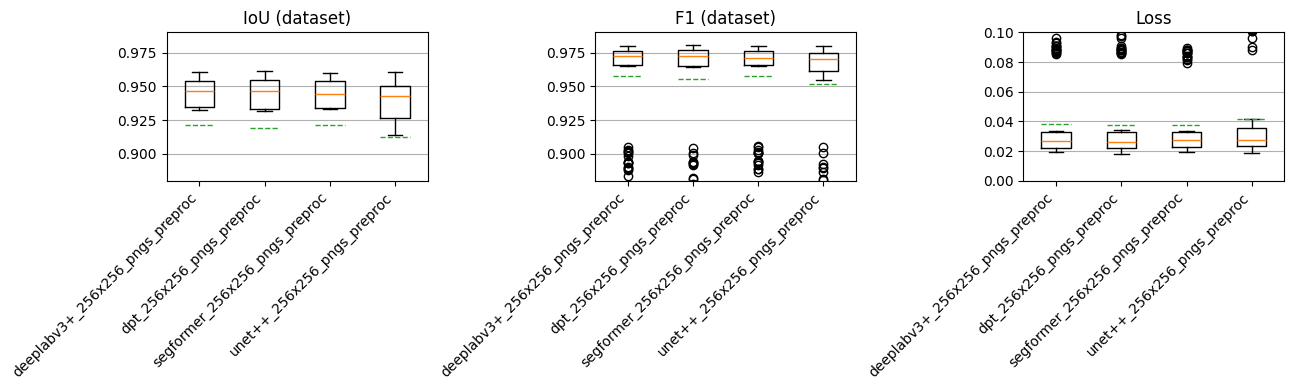

In [47]:
import matplotlib.pyplot as plt
import polars as pl

metrics = {
    "IoU (dataset)": "epoch_train_dataset_iou",
    "F1 (dataset)": "epoch_train_dataset_f1",
    "Loss": "epoch_avg_loss_train",
}

models = df_train["model"].unique().to_list()

fig, axs = plt.subplots(1, 3, figsize=(13, 4), dpi=100)

for ax, (title, col) in zip(axs, metrics.items()):
    data = [
        df_train.filter(pl.col("model") == m)[col].to_numpy()
        for m in models
    ]

    ax.boxplot(
        data,
        showmeans=True,
        meanline=True
    )

    ax.set_title(title)
    ax.set_xticks(range(1, len(models) + 1))
    ax.set_xticklabels(models, rotation=45, ha="right")
    ax.grid(True, axis="y")

    if title == "Loss":
        ax.set_ylim(0, 0.10)
    else:
        ax.set_ylim(0.88, 0.99)

plt.tight_layout()
plt.show()
